In [146]:
from lora.models.roberta_scratch import get_model
from omegaconf import OmegaConf

from transformers import RobertaTokenizer

from datasets import load_dataset
from torch.utils.data import DataLoader

import scipy as scp

import matplotlib
font = {'size':14}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn

import math

from copy import deepcopy

from tqdm import tqdm

from lora.compress.gregodec import GreGoDec
from lora.compress.tsvd import TSVD 

In [3]:
args = OmegaConf.load("../config.yaml")
weights_path = "../outputs/2024-04-25/08-40-45/scratch.pth"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = get_model(args)
model.load_state_dict(torch.load(weights_path))
model.to(device)

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [4]:
dataset = load_dataset("nyu-mll/glue", "sst2")
dataset = dataset.map(
    lambda e: tokenizer(
        e["sentence"],
        None,
        max_length=256,
        pad_to_max_length=True,
        return_token_type_ids=True,
    ),
    batched=True,
)
dataset.set_format(
            type="torch",
            columns=["input_ids", "token_type_ids", "attention_mask", "label"],
        )
dataloader = DataLoader(
            dataset["validation"],
            batch_size=16,
            shuffle=False,
            num_workers=4
)

In [15]:
# add a hook to get the token embeddings
activation = {}
def get_embeddings(name):
    def hook(model, input, output):
        activation[name] = output
    return hook
model.roberta_encoder.embeddings.register_forward_hook(get_embeddings('embeddings'))

In [13]:
for i, sentence in enumerate(dataset["validation"]['sentence']):
    print(f"{i}, {sentence}")


0, it 's a charming and often affecting journey . 
1, unflinchingly bleak and desperate 
2, allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . 
3, the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . 
4, it 's slow -- very , very slow . 
5, although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . 
6, a sometimes tedious film . 
7, or doing last year 's taxes with your ex-wife . 
8, you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . 
9, in exactly 89 minutes , most of which passed as slowly as if i 'd been sitting naked on an igloo , formula 51 sank from quirky to jerky to utter turkey . 
10, the mesmerizing performances of the leads keep the film grounded and keep the audience riveted . 
11, it takes a strange kind of laziness to waste the talents of robert forste

In [27]:
input_embeddings = []
progress = tqdm(dataloader)
model.eval()
with torch.no_grad():
    for data in progress:
        out = model(
            input_ids=data["input_ids"].long().to(device),
            attention_mask=data["attention_mask"].long().to(device),
            token_type_ids=data["token_type_ids"].long().to(device)
        )
        input_embeddings.extend(
            activation["embeddings"]
        )

100%|██████████| 55/55 [00:01<00:00, 27.92it/s]


In [45]:
# get weights of the ith layer
query = model.roberta_encoder.encoder.layer[0].attention.self.query
key = model.roberta_encoder.encoder.layer[0].attention.self.key
value = model.roberta_encoder.encoder.layer[0].attention.self.value

Wq = torch.vstack([query.weight.transpose(0, 1), query.bias]).detach().cpu().numpy()
Wk = torch.vstack([key.weight.transpose(0, 1), key.bias]).detach().cpu().numpy()
B = Wq @ Wk.T

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '$B = W_Q W_K^\\top$')

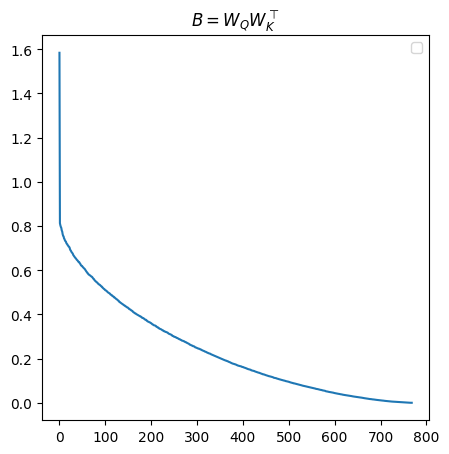

In [30]:
# plot spectrum of B
S = scp.linalg.svdvals(B)
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(list(range(len(S))), S)
ax.legend()
ax.set_title(r"$B = W_Q W_K^\top$")

In [141]:
U, V, S, _ = GreGoDec(
    B, 
    rank=1, 
    tau=0.001,
    tol=0.001,
    power=200,
    k=1
).fit()
Bhat_gregodec = U @ V + S

U, V = TSVD(
    B, 
    rank=1
).fit()
Bhat_tsvd = U @ V

In [148]:
def compute_error(Y, Yhat):
    return np.linalg.norm(Y - Yhat, ord='fro')/np.linalg.norm(Y, ord='fro')

In [159]:
idx = 758
dataset["validation"]['sentence'][idx]

"may be far from the best of the series , but it 's assured , wonderfully respectful of its past and thrilling enough to make it abundantly clear that this movie phenomenon has once again reinvented itself for a new generation . "

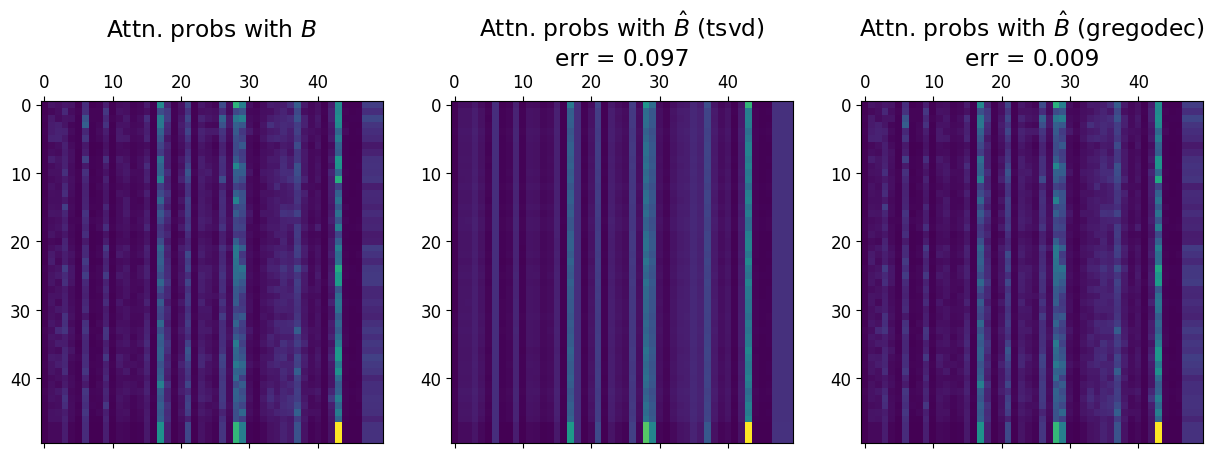

In [160]:
# get an embedded token sequence
X = input_embeddings[idx].detach().cpu()
x = torch.cat([X, torch.ones(X.size()[:-1] + (1,))], dim=-1).numpy()

Y = scp.special.softmax(x @ B @ x.T / np.sqrt(B.shape[0])) 
Yhat_t = scp.special.softmax(x @ Bhat_tsvd @ x.T / np.sqrt(B.shape[0])) 
Yhat_g = scp.special.softmax(x @ Bhat_gregodec @ x.T / np.sqrt(B.shape[0])) 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes[0]
ax.matshow(Y[:50, :50])
ax.set_title(r"Attn. probs with $B$" + "\n")

ax = axes[1]
ax.matshow(Yhat_t[:50, :50])
ax.set_title(r"Attn. probs with $\hat B$ (tsvd)" + "\n" + f"err = {compute_error(Y, Yhat_t):.3f}")

ax = axes[2]
ax.matshow(Yhat_g[:50, :50])
ax.set_title(r"Attn. probs with $\hat B$ (gregodec)" + "\n" + f"err = {compute_error(Y, Yhat_g):.3f}")

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [161]:
fig.savefig("attention-probs-2.pdf", bbox_inches='tight')